# Setup

First, let's import a few common modules, ensure MatploLib plots figures inline. 

In [1]:
import sys
import sklearn
import tensorflow as tf
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.4.0'

In [4]:
keras.__version__

'2.4.0'

# MINST

We will be using the MNIST dataset, which is a set of 70 000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much athat it is often called the "hello world" of ML. 

We start by loading the MNIST data set. Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already to split for you betwen a training set and a test set, but it can be usefull to split the training set further to have a validation set

In [5]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 24s 2us/step


In [7]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as abyte (0 to 255):

In [8]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a smaller set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255

In [9]:
X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.

We can plot an image using Matplotlib imsshow() function, with a 'binary' color map:

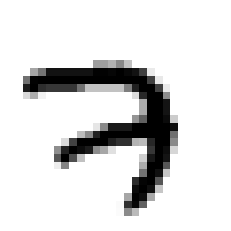

In [10]:
plt.imshow(X_train[0], cmap = 'binary')
plt.axis('off')
plt.show()

The labels are the class IDs (represented as unint8), from 0 to 9:

In [11]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

Here are the corresponding class names:

In [12]:
class_names = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]

The first image in the training set is number seven:

In [13]:
class_names[y_train[0]]

'seven'

The validation set contains 5000 images, and the test set contain 10 000 images

In [14]:
X_valid.shape

(5000, 28, 28)

In [15]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

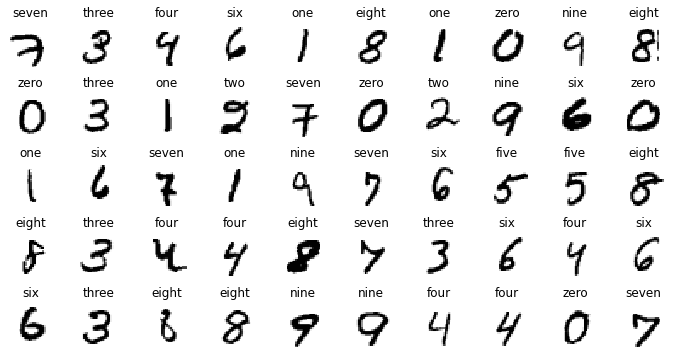

In [18]:
n_rows = 5
n_cols = 10
plt.figure(figsize = (n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap = 'binary', interpolation = 'nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize = 12)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()
        

# Creating the model using the Sequential API

Now let's buid the neural network. Here is a classification of MLP with tow hidden layers.

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax")
])

Let us explain this code explicitly:
* the first line create a <code>Sequential</code> model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. This is called Sequential API
* next we build the first layer and add it to the model. It is a <code>Flatten</code> layer whose role is to convert each input image into aa 1D array: if it receives input data X, it computes <code>X.reshape(-1,1)</code>. This layer does not have any parameters, it is just there to do some simple preprocessing. Sicne it is the first layer in the model, you should specify the <code>input_shape</code>, which does not include the batch size, only the shape of the instances. ALternatively, we could add aa <code>keras.layers.InputLayer</code> as the first layer, setting <code>input_shape = [28,28]</code>
* next we add a Dense layer with 300 neurons and their inputs. It also manages a vector of bias terms (one per neutron)
* then we add a second <code>Dense</code> hidden layer with 100 neurons (one per class), using the ReLU activation function
* finally, we add a <code>Dense</code> output layer with 10 neurons, using the softmax activation function

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


<code>Dense</code> layers often have a lot of parameters. For example, the first hidden layer has 784x300 connection weights plus 300 bias terms, which adds up 235500 parameters. This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when we do not have a lot of training data

In [21]:
model.layers

In [24]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [25]:
model.get_layer('dense') is hidden1

True

All the parameters of a layer can be accessed using its <code>get_weights()</code> and <code>set_weights()</code> methods. For a <code>Dense</code> layer, this includes both the connection weights and the bias terms:

In [26]:
weights, biases = hidden1.get_weights()

In [27]:
weights

array([[ 0.05571111,  0.05187698, -0.05693708, ..., -0.03814916,
         0.04489449, -0.0670267 ],
       [-0.06286049,  0.01215816, -0.01031297, ..., -0.02809022,
        -0.01071191, -0.00148153],
       [-0.01233863, -0.02249353, -0.00909907, ..., -0.03647979,
         0.00791907, -0.040305  ],
       ...,
       [-0.01724428, -0.00136191,  0.04537448, ...,  0.02432032,
        -0.01557208, -0.00716052],
       [ 0.04089485,  0.04619539,  0.01352428, ...,  0.00164475,
        -0.03691033,  0.04702777],
       [ 0.00254796,  0.01614916,  0.03474478, ..., -0.05225831,
        -0.05060289, -0.01534441]], dtype=float32)

In [28]:
weights.shape

(784, 300)

In [29]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [30]:
biases.shape

(300,)

# Compiling, training, and evaluating the model

After a model is created, we must call its <code>compile()</code> method to specify the loss function and the optimizer to use. Optionally, we can specify a list of extra metrics to compute during training and evaluation:

In [31]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = "adam",
             metrics = ["accuracy"])

In [32]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3604 - accuracy: 0.8923 - val_loss: 0.1040 - val_accuracy: 0.9698
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0833 - accuracy: 0.9745 - val_loss: 0.0814 - val_accuracy: 0.9752
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0537 - accuracy: 0.9826 - val_loss: 0.0809 - val_accuracy: 0.9752
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0429 - accuracy: 0.9861 - val_loss: 0.0878 - val_accuracy: 0.9748
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0342 - accuracy: 0.9887 - val_loss: 0.0741 - val_accuracy: 0.9806
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0233 - accuracy: 0.9925 - val_loss: 0.0682 - val_accuracy: 0.9822
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0199 - accuracy: 0.9929 - val_loss: 0.0813 - val_accuracy:

At each epoch during training, Keras displays the number of instances processed so far, the mean training time per sample, the loss and accurary on both the training set and the validation set. We can see that the trianing loss went down, which is a good sign, and the validation accuracy reached 98% with adam optimizer after 30 epochs. That is not too far from the training accuracy, so there does not seem to be much overfitting going on.

In [33]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [34]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

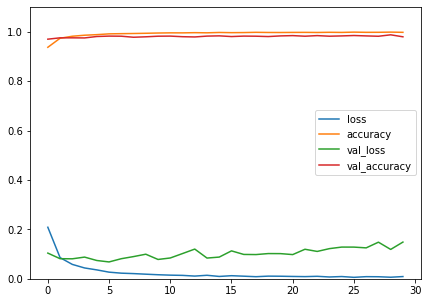

In [39]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize = (7,5))
plt.gca().set_ylim(0,1.1)
plt.show()

We can see that both the training accuracy and the validation accuracy increase slowly after 5 epochs, while the training loss and the validation loss decrease slowly. This is good! Moreover, the validation courves are close to the training curves, which means that there is not too much overfitting. 

The validation loss decreases very weakly after 10 epochs, thus our model is trained long enough.

Once we are satisfied with our model's validation accurary, we should evaluate it on the test set to estimate the generalisation error before we deply the model to production. We can easily do this using the <code>evaluate()</code> method

In [40]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.1575 - accuracy: 0.9787


[0.15753069519996643, 0.9786999821662903]

It is common to get slightly lower performance on the test set than on the validation set, because the hyperparameters are tuned on the valdation test.

# Using model to make predictions

Next we can use the model's <code>predict()</code> method to make predictions on new instances. Since we don't have actual new examples, we will just use the first five instances of the test set:

In [41]:
X_new = X_test[:5]
y_probability = model.predict(X_new)
y_probability.round(10)

array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+00,
        0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00],
       [0.e+00, 1.e+00, 0.e+00, 0.e+00, 5.e-10, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00],
       [1.e+00, 0.e+00, 2.e-10, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 3.e-10]], dtype=float32)

As we can see, for each examples the model extimates one probability per class, from class 0 to class 9. For example, for the first image it estimates that the probabilty of class 7 (number seven) is rounded up to 100%.

In [43]:
y_pred = model.predict_classes(X_new)
y_pred

array([7, 2, 1, 0, 4])

In [45]:
np.array(class_names)[y_pred]

array(['seven', 'two', 'one', 'zero', 'four'], dtype='<U5')

In [46]:
y_new = y_test[:5]
y_new

array([7, 2, 1, 0, 4], dtype=uint8)

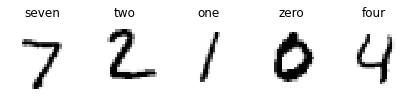

In [47]:
plt.figure(figsize = (7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap = "binary", interpolation = "nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize = 12)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()